#Setting up

In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 4.7MB/s 
     |████████████████████████████████| 14.7MB 274kB/s 
     |████████████████████████████████| 10.4MB 42.6MB/s 


In [0]:
import pandas as pd
import numpy as np
import datetime 
from geopandas import GeoDataFrame
from shapely.geometry import Polygon 
import fiona

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
# cv = StratifiedKFold(n_splits=3, shuffle=True)
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegression
 
#from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


This colab has vegetaion data with fire one week before fire as positive and 

all records one week before that as no fire -- and it also has the non fire grids (indices) as well for each fire day

#Import vegetation data

Below is 8 day aggregate vegetation data for all years from 2014 to 2019



In [0]:
downloaded_veg = drive.CreateFile({'id':'1eRfdmOvwxt5YgTeq_oHcnXo8fA18U13Y'}) 
downloaded_veg.GetContentFile('vegetation.csv')
veg_dat = pd.read_csv('vegetation.csv')
veg_dat.head()

,Unnamed: 0,left,top,right,bottom,id,geometry,Centroid Longitude,Centroid Latitude,Start Date,End Date,NDVI,EVI,NDWI,topLeft_coords,topRight_coords,bottomLeft_coords,bottomRight_coords,centroid_coords,midLeft_coords,midRight_coords,midTop_coords,midBottom_coords,diagonal1,diagonal2,diagonal3,diagonal4,fire_2018_COUNTY2,fire_2017_WINTER2,fire_2016_COLD2,fire_2015_WRAGG2,fire_2014_MONTICELLO2,target
0,0,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2014-01-01,2014-01-08,0.416393,0.340703,0.094683,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)","(-122.12143860916372, 38.566509784244744)","(-122.11693860916371, 38.566509784244744)","(-122.11693860916371, 38.56200978424475)","(-122.12143860916372, 38.56200978424475)",False,False,False,False,False,False
1,1,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2014-01-09,2014-01-16,0.416393,0.340703,0.094683,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)","(-122.12143860916372, 38.566509784244744)","(-122.11693860916371, 38.566509784244744)","(-122.11693860916371, 38.56200978424475)","(-122.12143860916372, 38.56200978424475)",False,False,False,False,False,False
2,2,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2014-01-17,2014-01-24,0.337617,0.310645,0.110320,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)","(-122.12143860916372, 38.566509784244744)","(-122.11693860916371, 38.566509784244744)","(-122.11693860916371, 38.56200978424475)","(-122.12143860916372, 38.56200978424475)",False,False,False,False,False,False
3,3,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2014-01-25,2014-02-01,0.258841,0.280587,0.125957,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)","(-122.12143860916372, 38.566509784244744)","(-122.11693860916371, 38.566509784244744)","(-122.11693860916371, 38.56200978424475)","(-122.12143860916372, 38.56200978424475)",False,False,False,False,False,False
4,4,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2014-02-02,2014-02-09,0.180065,0.250529,0.141595,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)"

In [0]:
veg_dat.shape

(17388, 33)

#Filter vegetation data fro years - 2015,2016,2017,2018 as we do no have 2014 weather data

In [0]:
veg_dat['Start Date'] = pd.to_datetime(veg_dat['Start Date'])

In [0]:
veg_train = veg_dat[(veg_dat['Start Date'] > datetime.datetime(2014, 12, 31)) & (veg_dat['Start Date'] < datetime.datetime(2019, 1, 1))]

In [0]:
veg_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11592 entries, 46 to 17341
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             11592 non-null  int64         
 1   left                   11592 non-null  float64       
 2   top                    11592 non-null  float64       
 3   right                  11592 non-null  float64       
 4   bottom                 11592 non-null  float64       
 5   id                     11592 non-null  int64         
 6   geometry               11592 non-null  object        
 7   Centroid Longitude     11592 non-null  float64       
 8   Centroid Latitude      11592 non-null  float64       
 9   Start Date             11592 non-null  datetime64[ns]
 10  End Date               11592 non-null  object        
 11  NDVI                   11592 non-null  float64       
 12  EVI                    11592 non-null  float64       
 13  

#Convert target to 0 and 1

In [0]:
veg_train['target'] = veg_train['target'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
veg_train['target'].value_counts()

0    11470
1      122
Name: target, dtype: int64

2015 fire : start- 2015/07/22 end -2015/08/05  

2016 fire : start- 2016/08/02 end - 2016/08/09

2017 fire : start- 2017/07/06 end - 2017/07/12

2018 fire : start- 2018/06/30 end - 2018/07/11

#Create postive and negative vegetation data

In [0]:
#create 1 day layer of positive data
veg_2015_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2015-07-12'))] #positive 2015-07-12 negative 2015-07-04 --  8 day aggregate before fire 
veg_2016_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2016-07-27'))] #positive 2016-07-27 negative 2016-07-19 --8 day aggregate before fire, but for 2016 we took next record as the fire started on 2016-08-2  
veg_2017_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2017-06-26'))] #positive 2017-06-26 negative 2017-06-18 --  8 day aggregate before fire 
veg_2018_positive = veg_train[(veg_train['Start Date'] == pd.to_datetime('2018-06-18'))] #positive 2018-06-18   negative 2018-06-10 --  8 day aggregate before fire 

In [0]:
veg_wragg = veg_train[veg_train['fire_2015_WRAGG2'] == True]
veg_cold = veg_train[veg_train['fire_2016_COLD2'] == True]
veg_winter = veg_train[veg_train['fire_2017_WINTER2'] == True]
veg_county = veg_train[veg_train['fire_2018_COUNTY2'] == True]

In [0]:
veg_2015_index = veg_wragg['id'].value_counts().index.tolist()
veg_2016_index = veg_cold['id'].value_counts().index.tolist()
veg_2017_index = veg_winter['id'].value_counts().index.tolist()
veg_2018_index = veg_county['id'].value_counts().index.tolist()

In [0]:
veg_2015_index

[63, 28, 27, 56, 55, 21, 20, 49, 48, 14, 13, 42, 41, 7, 35, 34]

In [0]:
veg_2015_positive.loc[veg_2015_positive['id'].isin(veg_2015_index), 'target'] = 1
veg_2015_positive.loc[~veg_2015_positive['id'].isin(veg_2015_index), 'target'] = 0
veg_2016_positive.loc[veg_2016_positive['id'].isin(veg_2016_index), 'target'] = 1
veg_2016_positive.loc[~veg_2016_positive['id'].isin(veg_2016_index), 'target'] = 0
veg_2017_positive.loc[veg_2017_positive['id'].isin(veg_2017_index), 'target'] = 1
veg_2017_positive.loc[~veg_2017_positive['id'].isin(veg_2017_index), 'target'] = 0
veg_2018_positive.loc[veg_2018_positive['id'].isin(veg_2018_index), 'target'] = 1
veg_2018_positive.loc[~veg_2018_positive['id'].isin(veg_2018_index), 'target'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
print(veg_2015_positive['target'].value_counts())
print(len(veg_2015_index))

0    47
1    16
Name: target, dtype: int64
16


In [0]:
print(veg_2016_positive['target'].value_counts())
print(len(veg_2016_index))

1    43
0    20
Name: target, dtype: int64
43


In [0]:
print(veg_2017_positive['target'].value_counts())
print(len(veg_2017_index))

0    46
1    17
Name: target, dtype: int64
17


In [0]:
print(veg_2018_positive['target'].value_counts())
print(len(veg_2018_index))

1    46
0    17
Name: target, dtype: int64
46


In [0]:
#create 1 day layer of empty data
veg_2015_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2015-07-04'))]
veg_2016_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2016-07-19'))]
veg_2017_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2017-06-18'))]
veg_2018_empty = veg_train[(veg_train['Start Date'] == pd.to_datetime('2018-06-10'))]

In [0]:
veg_2015_empty.columns

Index(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry',
       'Centroid Longitude', 'Centroid Latitude', 'Start Date', 'End Date',
       'NDVI', 'EVI', 'NDWI', 'topLeft_coords', 'topRight_coords',
       'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
       'midLeft_coords', 'midRight_coords', 'midTop_coords',
       'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
       'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
       'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'],
      dtype='object')

#Vegetation seperate model

In [0]:
#individual vegetation model
veg_2018_positive.shape

(63, 33)

In [0]:
veg_data = pd.concat([veg_2015_empty, veg_2016_empty, veg_2017_empty,veg_2018_empty,veg_2015_positive,veg_2016_positive,veg_2017_positive,veg_2018_positive], axis = 0, ignore_index=True)

In [0]:
veg_data.target.value_counts()

0    382
1    122
Name: target, dtype: int64

In [0]:
# #Filter and seperate train and test based on years 
# def filter_data_train(year_del,data):
#   X_Train = data[~(data['Start Date'].dt.year == year_del)].reset_index(drop=True).drop(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry', 'Start Date', 'End Date',
#        'topLeft_coords', 'topRight_coords',
#        'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
#        'midLeft_coords', 'midRight_coords', 'midTop_coords',
#        'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
#        'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
#        'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'], axis=1)
#   Y_Train = data[~(data['Start Date'].dt.year == year_del)]['target']
#   X_Test = data[data['Start Date'].dt.year == year_del].reset_index(drop=True).drop(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry', 'Start Date', 'End Date',
#        'topLeft_coords', 'topRight_coords',
#        'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
#        'midLeft_coords', 'midRight_coords', 'midTop_coords',
#        'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
#        'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
#        'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'], axis=1)
#   Y_Test = data[data['Start Date'].dt.year == year_del]['target']
#   return X_Train,X_Test,Y_Train, Y_Test
# # X_train['Start Date'].dt.year.value_counts()
# # X_test['Start Date'].dt.year.value_counts()
# X_train, X_test, y_train, y_test = filter_data_train(2018,data)

In [0]:
# rf_veg = RandomForestClassifier(n_estimators = 200, random_state = 42)
# rf_veg.fit(X_train, y_train)
# predictions = rf_veg.predict(X_test)
# numpy_data = np.array([predictions, y_test])
# result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])
# result['error'] = result['predict'] - result['target']
# correct = result[result['error'] == 0]
# print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))
# actual = y_test
# predicted = predictions
# results = confusion_matrix(actual, predicted) 
  
# print('Confusion Matrix :')
# print(results) 
# print('Accuracy Score :',accuracy_score(actual, predicted))
# print('Report : ')
# print(classification_report(actual, predicted))

In [0]:
X_1 = veg_data.reset_index(drop=True).drop(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry', 'Start Date', 'End Date',
       'topLeft_coords', 'topRight_coords',
       'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
       'midLeft_coords', 'midRight_coords', 'midTop_coords',
       'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
       'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
       'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'], axis=1)

In [0]:
#  'id', 'Start Date'

In [0]:
X_1.columns

Index(['Centroid Longitude', 'Centroid Latitude', 'NDVI', 'EVI', 'NDWI'], dtype='object')

In [0]:
y_1 = veg_data['target']


In [0]:
X_1.shape

(504, 5)

In [0]:
# import imblearn
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X_1, y_1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
y.shape

(764,)

In [0]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify= y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [0]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
# from sklearn.preprocessing import StandardScaler
# # cv = StratifiedKFold(n_splits=3, shuffle=True)
# from sklearn.model_selection import GridSearchCV
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.metrics import confusion_matrix 
# from sklearn.metrics import accuracy_score 
# from sklearn.metrics import classification_report 

In [0]:
rf_veg = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf_veg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
predictions = rf_veg.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
actual = y_test
predicted = predictions
results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual, predicted)*100,3))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[65 11]
 [11 66]]
Accuracy Score : 85.621
Report : 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        76
           1       0.86      0.86      0.86        77

    accuracy                           0.86       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.86      0.86      0.86       153



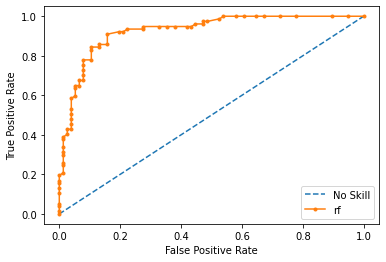

In [0]:
# roc curve
yhat = rf_veg.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.430000, G-Mean=0.875


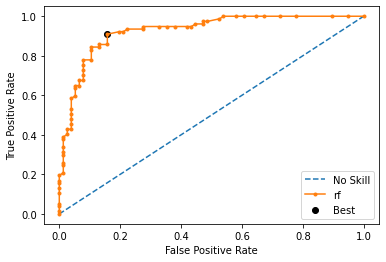

In [0]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
threshold = 0.4

predicted_proba = rf_veg.predict_proba(X_test)
predicted10 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted10)
print(accuracy)

0.8562091503267973


In [0]:
actual10 = y_test
results = confusion_matrix(actual10, predicted10) 
print('Threshold: ', threshold)
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual10, predicted10)*100,3))
print('Report : ')
print(classification_report(actual, predicted10))

Threshold:  0.4
Confusion Matrix :
[[59 17]
 [ 5 72]]
Accuracy Score : 85.621
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        76
           1       0.81      0.94      0.87        77

    accuracy                           0.86       153
   macro avg       0.87      0.86      0.86       153
weighted avg       0.87      0.86      0.86       153



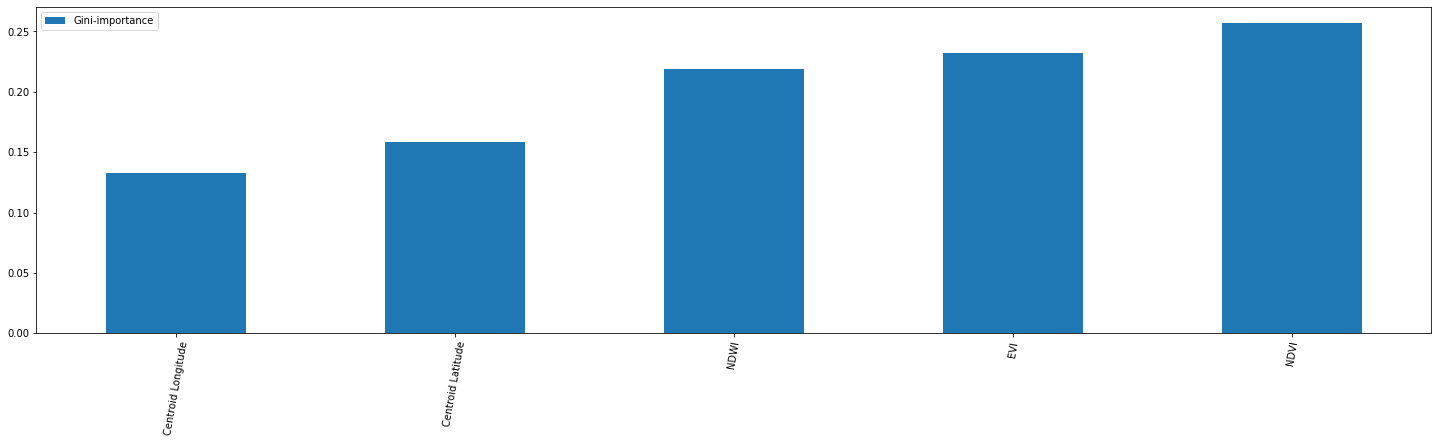

In [0]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_1.columns, rf_veg.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=80, figsize=(25, 6))

In [0]:
# from sklearn.datasets import load_iris
# iris = load_iris()

# # Model (can also use single decision tree)
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=10)

# # Train
# model.fit(iris.data, iris.target)
# # Extract single tree
estimator = rf_veg.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_1.columns,
                class_names = ['Positive','Negative'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


0

In [0]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png', height=500)

## save to drive

In [0]:
tableau_veg_X = veg_data.reset_index(drop=True).drop(['Unnamed: 0', 'left', 'top', 'right', 'bottom', 'id', 'geometry', 'Start Date', 'End Date',
       'topLeft_coords', 'topRight_coords',
       'bottomLeft_coords', 'bottomRight_coords', 'centroid_coords',
       'midLeft_coords', 'midRight_coords', 'midTop_coords',
       'midBottom_coords', 'diagonal1', 'diagonal2', 'diagonal3', 'diagonal4',
       'fire_2018_COUNTY2', 'fire_2017_WINTER2', 'fire_2016_COLD2',
       'fire_2015_WRAGG2', 'fire_2014_MONTICELLO2', 'target'], axis=1)

In [0]:
tableau_veg_y = veg_data['target']

In [0]:
predict = rf_veg.predict(tableau_veg_X)
proba = rf_veg.predict_proba(tableau_veg_X)


In [0]:
veg_data['predictions'] = predict
veg_data['prob_0'] = proba[:,0] 
veg_data['prob_1'] = proba[:,1]

In [0]:
veg_data.head()

,Unnamed: 0,left,top,right,bottom,id,geometry,Centroid Longitude,Centroid Latitude,Start Date,End Date,NDVI,EVI,NDWI,topLeft_coords,topRight_coords,bottomLeft_coords,bottomRight_coords,centroid_coords,midLeft_coords,midRight_coords,midTop_coords,midBottom_coords,diagonal1,diagonal2,diagonal3,diagonal4,fire_2018_COUNTY2,fire_2017_WINTER2,fire_2016_COLD2,fire_2015_WRAGG2,fire_2014_MONTICELLO2,target,predictions,prob_0,prob_1
0,69,-122.124189,38.56926,-122.114189,38.55926,1,POLYGON ((-122.1241886091637 38.56925978424475...,-122.119189,38.56426,2015-07-04,2015-07-11,0.486477,0.407889,0.120923,"(-122.1241886091637, 38.56925978424475)","(-122.11418860916369, 38.56925978424475)","(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.11918860916371, 38.56425978424475)","(-122.1241886091637, 38.56425978424475)","(-122.11418860916369, 38.56425978424475)","(-122.11918860916371, 38.56925978424475)","(-122.11918860916371, 38.55925978424475)","(-122.12143860916372, 38.566509784244744)","(-122.11693860916371, 38.566509784244744)","(-122.11693860916371, 38.56200978424475)","(-122.12143860916372, 38.56200978424475)",False,False,False,False,False,0,0,1.000,0.000
1,345,-122.124189,38.55926,-122.114189,38.54926,2,POLYGON ((-122.1241886091637 38.55925978424475...,-122.119189,38.55426,2015-07-04,2015-07-11,0.443379,0.342385,0.085150,"(-122.1241886091637, 38.55925978424475)","(-122.11418860916369, 38.55925978424475)","(-122.1241886091637, 38.549259784244754)","(-122.11418860916369, 38.549259784244754)","(-122.11918860916371, 38.554259784244756)","(-122.1241886091637, 38.554259784244756)","(-122.11418860916369, 38.554259784244756)","(-122.11918860916371, 38.55925978424475)","(-122.11918860916371, 38.549259784244754)","(-122.12143860916372, 38.55650978424475)","(-122.11693860916371, 38.55650978424475)","(-122.11693860916371, 38.55200978424476)","(-122.12143860916372, 38.55200978424476)",False,False,False,False,False,0,0,0.975,0.025
2,621,-122.124189,38.54926,-122.114189,38.53926,3,POLYGON ((-122.1241886091637 38.54925978424475...,-122.119189,38.54426,2015-07-04,2015-07-11,0.414332,0.322549,0.064991,"(-122.1241886091637, 38.54925978424475)","(-122.11418860916369, 38.54925978424475)","(-122.1241886091637, 38.53925978424475)","(-122.11418860916369, 38.53925978424475)","(-122.11918860916371, 38.54425978424475)","(-122.1241886091637, 38.54425978424475)","(-122.11418860916369, 38.54425978424475)","(-122.11918860916371, 38.54925978424475)","(-122.11918860916371, 38.53925978424475)","(-122.12143860916372, 38.54650978424475)","(-122.11693860916371, 38.54650978424475)","(-122.11693860916371, 38.542009784244755)","(-122.12143860916372, 38.542009784244755)",False,False,False,False,False,0,0,0.815,0.185
3,897,-122.124189,38.53926,-122.114189,38.52926,4,POLYGON ((-122.1241886091637 38.53925978424475...,-122.119189,38.53426,2015-07-04,2015-07-11,0.432825,0.346805,0.098064,"(-122.1241886091637, 38.53925978424475)","(-122.11418860916369, 38.53925978424475)","(-122.1241886091637, 38.52925978424475)","(-122.11418860916369, 38.52925978424475)","(-122.11918860916371, 38.53425978424475)","(-122.1241886091637, 38.53425978424475)","(-122.11418860916369, 38.53425978424475)","(-122.11918860916371, 38.53925978424475)","(-122.11918860916371, 38.52925978424475)","(-122.12143860916372, 38.53650978424475)","(-122.11693860916371, 38.53650978424475)","(-122.11693860916371, 38.53200978424476)","(-122.12143860916372, 38.53200978424476)",False,False,False,False,False,0,0,0.960,0.040
4,1173,-122.124189,38.52926,-122.114189,38.51926,5,POLYGON ((-122.1241886091637 38.52925978424475...,-122.119189,38.52426,2015-07-04,2015-07-11,0.352972,0.292811,0.105769,"(-122.1241886091637, 38.52925978424475)","(-122.11418860916369, 38.52925978424475)","(-122.1241886091637, 38.51925978424475)","(-122.11418860916369, 38.51925978424475)","(-122.11918860916371, 38.524259784244755)","(-122.1241886091637, 38.524259784244755)","(-122.11418860916369, 38.524259784244755)","(-1

In [0]:
from google.colab import drive as dr
dr.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction/predicted_csvfiles/'

In [0]:
root_path+ 'b'

'/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction/predicted_csvfiles/b'

In [0]:
root_path

'/content/gdrive/My Drive/Colab Notebooks/MasterProject_WildFirePrediction/predicted_csvfiles/'

In [0]:
# veg_data.to_csv(root_path +'veg_data.csv')

# Download Positive weather data

In [0]:
# downloaded1 = drive.CreateFile({'id':'1EMqiSn9snQCPicKFfiHhxir1yzEMoKDU'}) 
# downloaded1.GetContentFile('WRAGG_2015_test.csv')
# weather_2015_positive = pd.read_csv('WRAGG_2015_test.csv')
# weather_2015_positive['target'].value_counts()

In [0]:
downloaded1 = drive.CreateFile({'id':'1EMqiSn9snQCPicKFfiHhxir1yzEMoKDU'}) 
downloaded1.GetContentFile('WRAGG_2015_test.csv')
dat_2015 = pd.read_csv('WRAGG_2015_test.csv')
dat_2015['target'].value_counts()

0    1128
1     384
Name: target, dtype: int64

In [0]:
dat_2015['DATE'].value_counts()

2015-07-22 16:53:00    63
2015-07-22 04:53:00    63
2015-07-22 14:53:00    63
2015-07-22 12:53:00    63
2015-07-22 03:53:00    63
2015-07-22 05:53:00    63
2015-07-22 22:53:00    63
2015-07-22 20:53:00    63
2015-07-22 19:53:00    63
2015-07-22 23:53:00    63
2015-07-22 15:53:00    63
2015-07-22 11:53:00    63
2015-07-22 09:53:00    63
2015-07-22 06:53:00    63
2015-07-22 01:53:00    63
2015-07-22 18:53:00    63
2015-07-22 21:53:00    63
2015-07-22 13:53:00    63
2015-07-22 17:53:00    63
2015-07-22 00:53:00    63
2015-07-22 08:53:00    63
2015-07-22 07:53:00    63
2015-07-22 10:53:00    63
2015-07-22 02:53:00    63
Name: DATE, dtype: int64

In [0]:
downloaded2 = drive.CreateFile({'id':'1-2ZD_NZcxQQ-T-1DszSiNNeCo6ibx2Ht'}) 
downloaded2.GetContentFile('COLD_2016_test.csv')
dat_2016 = pd.read_csv('COLD_2016_test.csv')
dat_2016['target'].value_counts()

1    1032
0     480
Name: target, dtype: int64

In [0]:
dat_2016['DATE'].value_counts()

2016-08-02 05:53:00    63
2016-08-02 23:53:00    63
2016-08-02 21:53:00    63
2016-08-02 08:53:00    63
2016-08-02 12:53:00    63
2016-08-02 04:53:00    63
2016-08-02 10:53:00    63
2016-08-02 11:53:00    63
2016-08-02 03:53:00    63
2016-08-02 20:53:00    63
2016-08-02 19:53:00    63
2016-08-02 09:53:00    63
2016-08-02 14:53:00    63
2016-08-02 02:53:00    63
2016-08-02 13:53:00    63
2016-08-02 01:53:00    63
2016-08-02 22:53:00    63
2016-08-02 00:53:00    63
2016-08-02 15:53:00    63
2016-08-02 16:53:00    63
2016-08-02 06:53:00    63
2016-08-02 18:53:00    63
2016-08-02 17:53:00    63
2016-08-02 07:53:00    63
Name: DATE, dtype: int64

In [0]:
downloaded3 = drive.CreateFile({'id':'1-6ATDvR4YZn7j9fcnaQc1ZRLhMFY6ovs'}) 
downloaded3.GetContentFile('WINTER_2017during_train.csv')
dat_2017 = pd.read_csv('WINTER_2017during_train.csv')
dat_2017['target'].value_counts()

0    1104
1     408
Name: target, dtype: int64

In [0]:
dat_2017['DATE'].value_counts()

2017-07-06 22:53:00    63
2017-07-06 21:53:00    63
2017-07-06 00:53:00    63
2017-07-06 18:53:00    63
2017-07-06 06:53:00    63
2017-07-06 16:53:00    63
2017-07-06 07:53:00    63
2017-07-06 02:53:00    63
2017-07-06 12:53:00    63
2017-07-06 05:53:00    63
2017-07-06 13:53:00    63
2017-07-06 11:53:00    63
2017-07-06 17:53:00    63
2017-07-06 08:53:00    63
2017-07-06 04:53:00    63
2017-07-06 19:53:00    63
2017-07-06 23:53:00    63
2017-07-06 20:53:00    63
2017-07-06 15:53:00    63
2017-07-06 10:53:00    63
2017-07-06 09:53:00    63
2017-07-06 14:53:00    63
2017-07-06 03:53:00    63
2017-07-06 01:53:00    63
Name: DATE, dtype: int64

In [0]:
downloaded8 = drive.CreateFile({'id':'1-CR7IkiZ2PnNROZQqBpkZDDpqzMT-NQN'}) 
downloaded8.GetContentFile('COUNTY_2018during_train.csv')
dat_2018 = pd.read_csv('COUNTY_2018during_train.csv')
dat_2018['target'].value_counts()

1    1104
0     408
Name: target, dtype: int64

In [0]:
dat_2018['DATE'].value_counts()

2018-06-30 02:53:00    63
2018-06-30 23:53:00    63
2018-06-30 19:53:00    63
2018-06-30 07:53:00    63
2018-06-30 10:53:00    63
2018-06-30 06:53:00    63
2018-06-30 21:53:00    63
2018-06-30 08:53:00    63
2018-06-30 05:53:00    63
2018-06-30 20:53:00    63
2018-06-30 17:53:00    63
2018-06-30 04:53:00    63
2018-06-30 22:53:00    63
2018-06-30 14:53:00    63
2018-06-30 12:53:00    63
2018-06-30 09:53:00    63
2018-06-30 11:53:00    63
2018-06-30 00:53:00    63
2018-06-30 13:53:00    63
2018-06-30 15:53:00    63
2018-06-30 03:53:00    63
2018-06-30 01:53:00    63
2018-06-30 18:53:00    63
2018-06-30 16:53:00    63
Name: DATE, dtype: int64

# Dowload negative weather data

2015 -- negative weather date - 2015-07-11

2016 -- negative weather date - 2016-07-26

2017 -- negative weather date - 2017-06-25

2018 -- negative weather date - 2018-06-17

In [0]:
downloaded4 = drive.CreateFile({'id':'1Owi-fRO1nAsflHLloBilzOsdGePsXRIQ'}) # https://drive.google.com/open?id=1Owi-fRO1nAsflHLloBilzOsdGePsXRIQ 
downloaded4.GetContentFile('WRAGG_2015before_train.csv')
empty_2015 = pd.read_csv('WRAGG_2015before_train.csv')
empty_2015['target'] = 0
empty_2015['target'].value_counts()

0    1512
Name: target, dtype: int64

In [0]:
empty_2015['DATE'].value_counts()

2015-07-11 03:53:00    63
2015-07-11 01:53:00    63
2015-07-11 12:53:00    63
2015-07-11 23:53:00    63
2015-07-11 21:53:00    63
2015-07-11 17:53:00    63
2015-07-11 07:53:00    63
2015-07-11 00:53:00    63
2015-07-11 08:53:00    63
2015-07-11 02:53:00    63
2015-07-11 06:53:00    63
2015-07-11 11:53:00    63
2015-07-11 16:53:00    63
2015-07-11 20:53:00    63
2015-07-11 18:53:00    63
2015-07-11 10:53:00    63
2015-07-11 04:53:00    63
2015-07-11 05:53:00    63
2015-07-11 13:53:00    63
2015-07-11 15:53:00    63
2015-07-11 09:53:00    63
2015-07-11 14:53:00    63
2015-07-11 19:53:00    63
2015-07-11 22:53:00    63
Name: DATE, dtype: int64

In [0]:
downloaded5 = drive.CreateFile({'id':'1-2XPDpG_njoiFDfrGtAuUuNivhW-0f7W'}) # https://drive.google.com/open?id=1-2XPDpG_njoiFDfrGtAuUuNivhW-0f7W
downloaded5.GetContentFile('COLD_2016before_train.csv')
empty_2016 = pd.read_csv('COLD_2016before_train.csv')
empty_2016['target'] = 0
empty_2016['target'].value_counts()

0    1512
Name: target, dtype: int64

In [0]:
downloaded6 = drive.CreateFile({'id':'1-3gwEb8ql1UuBrOoC2b7vU0w-OWUga0V'}) #https://drive.google.com/open?id=1-3gwEb8ql1UuBrOoC2b7vU0w-OWUga0V
downloaded6.GetContentFile('WINTER_2017before_train.csv')
empty_2017 = pd.read_csv('WINTER_2017before_train.csv')
empty_2017['target'] = 0
empty_2017['target'].value_counts()

0    1512
Name: target, dtype: int64

In [0]:
empty_2017['DATE'].value_counts()

2017-07-06 22:53:00    63
2017-07-06 21:53:00    63
2017-07-06 00:53:00    63
2017-07-06 18:53:00    63
2017-07-06 06:53:00    63
2017-07-06 16:53:00    63
2017-07-06 07:53:00    63
2017-07-06 02:53:00    63
2017-07-06 12:53:00    63
2017-07-06 05:53:00    63
2017-07-06 13:53:00    63
2017-07-06 11:53:00    63
2017-07-06 17:53:00    63
2017-07-06 08:53:00    63
2017-07-06 04:53:00    63
2017-07-06 19:53:00    63
2017-07-06 23:53:00    63
2017-07-06 20:53:00    63
2017-07-06 15:53:00    63
2017-07-06 10:53:00    63
2017-07-06 09:53:00    63
2017-07-06 14:53:00    63
2017-07-06 03:53:00    63
2017-07-06 01:53:00    63
Name: DATE, dtype: int64

In [0]:
downloaded9 = drive.CreateFile({'id':'1-8G2Jhuy9c5yxR3m3YSICn4ps7ljrnTw'}) #https://drive.google.com/open?id=1-8G2Jhuy9c5yxR3m3YSICn4ps7ljrnTw
downloaded9.GetContentFile('COUNTY_2018before_train.csv')
empty_2018 = pd.read_csv('COUNTY_2018before_train.csv')
empty_2018['target'] = 0
empty_2018['target'].value_counts()

0    1512
Name: target, dtype: int64

In [0]:
empty_2018['DATE'].value_counts()

2018-06-30 02:53:00    63
2018-06-30 23:53:00    63
2018-06-30 19:53:00    63
2018-06-30 07:53:00    63
2018-06-30 10:53:00    63
2018-06-30 06:53:00    63
2018-06-30 21:53:00    63
2018-06-30 08:53:00    63
2018-06-30 05:53:00    63
2018-06-30 20:53:00    63
2018-06-30 17:53:00    63
2018-06-30 04:53:00    63
2018-06-30 22:53:00    63
2018-06-30 14:53:00    63
2018-06-30 12:53:00    63
2018-06-30 09:53:00    63
2018-06-30 11:53:00    63
2018-06-30 00:53:00    63
2018-06-30 13:53:00    63
2018-06-30 15:53:00    63
2018-06-30 03:53:00    63
2018-06-30 01:53:00    63
2018-06-30 18:53:00    63
2018-06-30 16:53:00    63
Name: DATE, dtype: int64

#Powerlines and terrain data

In [0]:
downloaded_terrain = drive.CreateFile({'id':'1RG_o-OU1BHhmdmi6BO9xWvjKY3IMazJp'}) 
downloaded_terrain.GetContentFile('terrain.csv')
terrain = pd.read_csv('terrain.csv')
terrain.head()

,Unnamed: 0,geometry,left,top,right,bottom,id,Ascpect_Range,hillshade_direction,slope_range
0,0,MULTIPOLYGON (((-122.0541886091637 38.53925978...,-122.054189,38.53926,-122.044189,38.52926,53,South East,North,High Slope
1,1,MULTIPOLYGON (((-122.0541886091637 38.52925978...,-122.054189,38.52926,-122.044189,38.51926,54,South,North,High Slope
2,2,MULTIPOLYGON (((-122.0541886091637 38.55925978...,-122.054189,38.55926,-122.044189,38.54926,51,South East,North,High Slope
3,3,MULTIPOLYGON (((-122.0541886091637 38.54925978...,-122.054189,38.54926,-122.044189,38.53926,52,South East,North,High Slope
4,4,MULTIPOLYGON (((-122.0641886091637 38.50925978...,-122.064189,38.50926,-122.054189,38.49926,49,South East,North,High Slope


In [0]:
downloaded_powerlines = drive.CreateFile({'id':'1znnGM0Xvz6jyNykLY7U5BZvvPCShiK9W'}) 
downloaded_powerlines.GetContentFile('powerlinefinal.csv')
powerline = pd.read_csv('powerlinefinal.csv')
powerline.head()

,Unnamed: 0,left,top,right,bottom,id,kV,Status,Circuit,Length_Mil,Length_Fee,geometry
0,0,-122.094189,38.54926,-122.084189,38.53926,24,0.0,Not Operating,Other,0,0.0,MULTIPOLYGON (((-122.0941886091637 38.54925978...
1,1,-122.094189,38.53926,-122.084189,38.52926,25,0.0,Not Operating,Other,0,0.0,MULTIPOLYGON (((-122.0941886091637 38.53925978...
2,2,-122.094189,38.56926,-122.084189,38.55926,22,0.0,Not Operating,Other,0,0.0,MULTIPOLYGON (((-122.0941886091637 38.56925978...
3,3,-122.094189,38.55926,-122.084189,38.54926,23,0.0,Not Operating,Other,0,0.0,MULTIPOLYGON (((-122.0941886091637 38.55925978...
4,4,-122.114189,38.54926,-122.104189,38.53926,10,0.0,Not Operating,Other,0,0.0,MULTIPOLYGON (((-122.1141886091637 38.54925978...


#seperate weather model terrain and powerlines

In [0]:
# print(write)

In [0]:
wea_data = pd.concat([empty_2018, empty_2017, empty_2016,empty_2015,dat_2015,dat_2016,dat_2017,dat_2018], axis = 0, ignore_index=True)

In [0]:
terrain = terrain[['id', 'Ascpect_Range',	'hillshade_direction',	'slope_range']]
wea_veg_ter = pd.merge(wea_data, terrain, on='id')
powerline = powerline[['id', 'kV', 'Status',	'Circuit',	'Length_Mil',	'Length_Fee']]
wea_data = pd.merge(wea_veg_ter, powerline, on='id')

In [0]:
wea_data.shape

(12096, 25)

In [0]:
wea_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'Ascpect_Range',
       'hillshade_direction', 'slope_range', 'kV', 'Status', 'Circuit',
       'Length_Mil', 'Length_Fee'],
      dtype='object')

In [0]:
wea_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12096 entries, 0 to 12095
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                12096 non-null  int64  
 1   Unnamed: 0.1              12096 non-null  int64  
 2   WBAN                      12096 non-null  int64  
 3   DATE                      12096 non-null  object 
 4   HourlyDryBulbTemperature  12096 non-null  float64
 5   HourlyRelativeHumidity    12096 non-null  float64
 6   HourlyWindSpeed           12096 non-null  float64
 7   HourlyPrecipitation       12096 non-null  float64
 8   left                      12096 non-null  float64
 9   top                       12096 non-null  float64
 10  right                     12096 non-null  float64
 11  bottom                    12096 non-null  float64
 12  id                        12096 non-null  int64  
 13  Longitude                 12096 non-null  float64
 14  Latitu

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


In [0]:
wea_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'Ascpect_Range',
       'hillshade_direction', 'slope_range', 'kV', 'Status', 'Circuit',
       'Length_Mil', 'Length_Fee'],
      dtype='object')

In [0]:
categories = pd.get_dummies(wea_data[['Ascpect_Range','hillshade_direction','slope_range','Status','Circuit']])

In [0]:
wea_data = pd.concat([wea_data,categories],axis = 1) 

In [0]:
wea_data.drop(columns={'Ascpect_Range','hillshade_direction','slope_range','Status','Circuit'},inplace = True)

In [0]:
# veg_dat['Start Date'] = pd.to_datetime(veg_dat['Start Date'])

In [0]:
# data[~(pd.to_datetime(data['DATE']).dt.year == 2015)].reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
#         'left', 'top', 'right', 'bottom', 'id',
#        'target', 'geometry'], axis=1)

In [0]:
# #Filter and seperate train and test based on years and fit models
# def filter_data_weather_train(year_del,data):
#   X_Train = data[~(pd.to_datetime(data['DATE']).dt.year == year_del)].reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
#         'left', 'top', 'right', 'bottom', 'id',
#        'target', 'geometry'], axis=1)
#   Y_Train = data[~(pd.to_datetime(data['DATE']).dt.year == year_del)]['target']
#   X_Test = data[pd.to_datetime(data['DATE']).dt.year == year_del].reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
#         'left', 'top', 'right', 'bottom', 'id',
#        'target', 'geometry'], axis=1)
#   Y_Test = data[pd.to_datetime(data['DATE']).dt.year == year_del]['target']
#   return X_Train,X_Test,Y_Train, Y_Test
# # X_train['Start Date'].dt.year.value_counts()
# # X_test['Start Date'].dt.year.value_counts()
# X_train, X_test, y_train, y_test = filter_data_weather_train(2017,data)

In [0]:
X_1 = wea_data.reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
        'left', 'top', 'right', 'bottom', 'id',
       'target', 'geometry'], axis=1)
y_1 = wea_data['target']

In [0]:
len(X_1.columns)
X_1.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'kV', 'Length_Mil',
       'Length_Fee', 'Ascpect_Range_East', 'Ascpect_Range_North East',
       'Ascpect_Range_South', 'Ascpect_Range_South East',
       'Ascpect_Range_South West', 'hillshade_direction_East',
       'hillshade_direction_North', 'slope_range_High Slope',
       'slope_range_Low Slope', 'slope_range_Moderate Slope',
       'Status_Not Operating', 'Status_Operational', 'Circuit_Other',
       'Circuit_Single'],
      dtype='object')

In [0]:
import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X_1, y_1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=1)

In [0]:

rf_weather = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf_weather.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
predictions = rf_weather.predict(X_test)
# numpy_data = np.array([predictions, y_test])
# result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])
# result['error'] = result['predict'] - result['target']
# correct = result[result['error'] == 0]
# print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
actual = y_test
predicted = predictions
results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual, predicted)*100,3))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[1493  341]
 [ 324 1510]]
Accuracy Score : 81.87
Report : 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1834
           1       0.82      0.82      0.82      1834

    accuracy                           0.82      3668
   macro avg       0.82      0.82      0.82      3668
weighted avg       0.82      0.82      0.82      3668



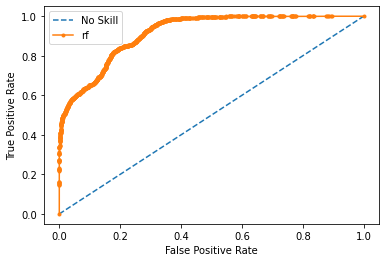

In [0]:
yhat = rf_weather.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.448750, G-Mean=0.820


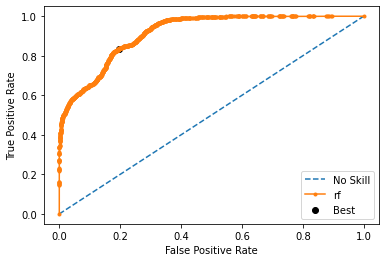

In [0]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
threshold = 0.4

predicted_proba = rf_weather.predict_proba(X_test)
predicted10 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted10)
print(accuracy)

0.816793893129771


In [0]:
actual10 = y_test
results = confusion_matrix(actual10, predicted10) 
print('Threshold value:', threshold)
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual10, predicted10)*100,3))
print('Report : ')
print(classification_report(actual, predicted10))

Threshold value: 0.4
Confusion Matrix :
[[1446  388]
 [ 284 1550]]
Accuracy Score : 81.679
Report : 
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1834
           1       0.80      0.85      0.82      1834

    accuracy                           0.82      3668
   macro avg       0.82      0.82      0.82      3668
weighted avg       0.82      0.82      0.82      3668



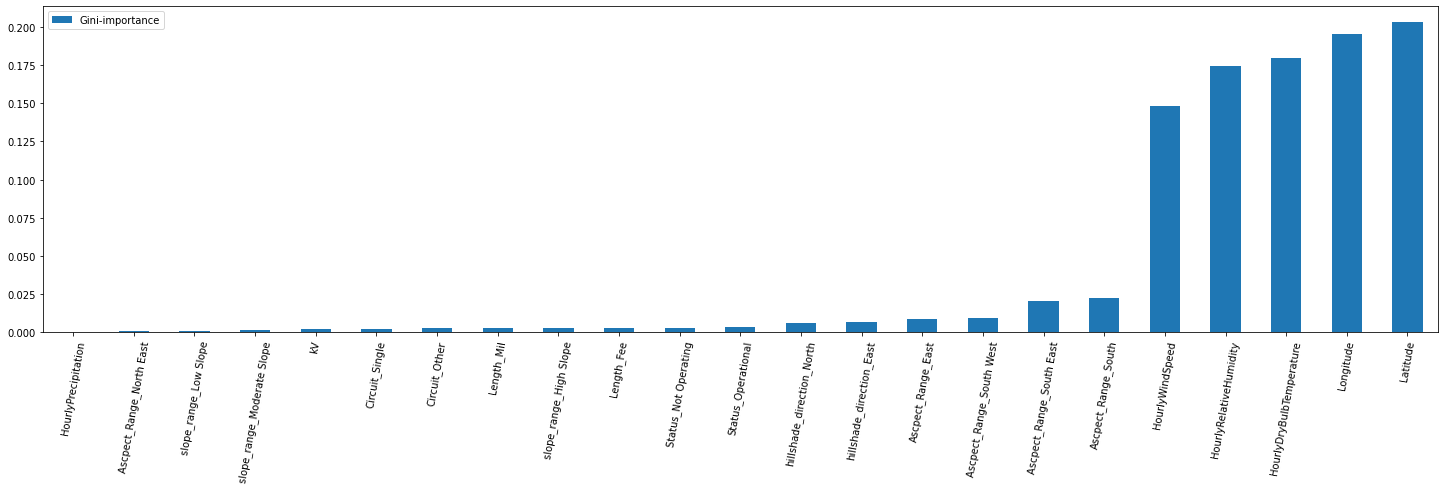

In [0]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_1.columns, rf_weather.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=80, figsize=(25, 6))

In [0]:
estimator = rf_weather.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_1.columns,
                class_names = ['Positive','Negative'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


0

In [0]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## save to drive

In [0]:
tableau_wea_X = wea_data.reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
        'left', 'top', 'right', 'bottom', 'id',
       'target', 'geometry'], axis=1)

In [0]:
tableau_wea_y = wea_data['target']

In [0]:
predict = rf_weather.predict(tableau_wea_X)
proba = rf_weather.predict_proba(tableau_wea_X)


In [0]:
wea_data['predictions'] = predict
wea_data['prob_0'] = proba[:,0] 
wea_data['prob_1'] = proba[:,1]

In [0]:
wea_data.head()

,Unnamed: 0,Unnamed: 0.1,WBAN,DATE,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlyPrecipitation,left,top,right,bottom,id,Longitude,Latitude,target,geometry,kV,Length_Mil,Length_Fee,Ascpect_Range_East,Ascpect_Range_North East,Ascpect_Range_South,Ascpect_Range_South East,Ascpect_Range_South West,hillshade_direction_East,hillshade_direction_North,slope_range_High Slope,slope_range_Low Slope,slope_range_Moderate Slope,Status_Not Operating,Status_Operational,Circuit_Other,Circuit_Single,predictions,prob_0,prob_1
0,0,5941351,93241,2018-06-30 00:53:00,66.0,59.0,0.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0.482667,0.517333
1,63,5941352,93241,2018-06-30 01:53:00,64.0,65.0,3.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0.355250,0.644750
2,126,5941353,93241,2018-06-30 02:53:00,64.0,63.0,3.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0.457500,0.542500
3,189,5941354,93241,2018-06-30 03:53:00,83.0,22.0,11.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0.450417,0.549583
4,252,5941355,93241,2018-06-30 04:53:00,82.0,22.0,10.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0.168333,0.831667


In [0]:
# wea_data.to_csv(root_path +'wea_data.csv')

#Combine weather data with vegetation data and also terrain and powerlines  (positive)

In [0]:
# def combine_datasets(weather, veg):
#   #first preprocess vegetation data
#   veg = veg[['id', 'NDVI', 'NDWI']]
#   dat = pd.merge(weather, veg, on='id')
#   return dat

def combine_datasets(weather, veg, terrain, powerlines):
  #first preprocess vegetation data
  veg = veg[['id', 'NDVI', 'NDWI','EVI']]
  wea_veg = pd.merge(weather, veg, on='id')
  terrain = terrain[['id', 'Ascpect_Range',	'hillshade_direction',	'slope_range']]
  wea_veg_ter = pd.merge(wea_veg, terrain, on='id')
  powerlines = powerlines[['id', 'kV', 'Status',	'Circuit',	'Length_Mil',	'Length_Fee']]
  dat = pd.merge(wea_veg_ter, powerlines, on='id')
  return dat

In [0]:
# dat_2015['id'].value_counts()

In [0]:
dat_2015 = combine_datasets(dat_2015, veg_2015_positive,terrain,powerline)

In [0]:
#veg_cold, veg_winter, veg_county
dat_2016 = combine_datasets(dat_2016, veg_2016_positive,terrain,powerline)
dat_2017 = combine_datasets(dat_2017, veg_2017_positive,terrain,powerline)
dat_2018 = combine_datasets(dat_2018, veg_2018_positive,terrain,powerline)

In [0]:
# dat_2018.shape

#Combine weather data with vegatation (negative)

In [0]:
# while we are considering weather and vegetation for fire grids during fire, i think we should consider same grids for before fire as well
negative_2015 = combine_datasets(empty_2015, veg_2015_empty,terrain,powerline)
negative_2016 = combine_datasets(empty_2016, veg_2016_empty,terrain,powerline)
negative_2017 = combine_datasets(empty_2017, veg_2017_empty,terrain,powerline)
negative_2018 = combine_datasets(empty_2018, veg_2018_empty,terrain,powerline)

# create combined training set

In [0]:
fire = pd.concat([dat_2015, dat_2016,dat_2018, dat_2018], axis = 0, ignore_index=True)

In [0]:
# fire['DATE'] = pd.to_datetime(fire['DATE'])
# fire['YEAR'] = fire['DATE'].apply(lambda x: x.year)
# fire['MONTH'] = fire['DATE'].apply(lambda x: x.month)
# fire['DAY'] = fire['DATE'].apply(lambda x: x.day)

In [0]:
no_fire = pd.concat([negative_2015,negative_2016,negative_2018,negative_2017], axis = 0, ignore_index=True)

In [0]:
# no_fire['DATE'] = pd.to_datetime(no_fire['DATE'])

In [0]:
# no_fire['YEAR'] = no_fire['DATE'].apply(lambda x: x.year)
# no_fire['MONTH'] = no_fire['DATE'].apply(lambda x: x.month)
# no_fire['DAY'] = no_fire['DATE'].apply(lambda x: x.day)

In [0]:
train = pd.concat([fire, no_fire], axis=0, ignore_index=True)

In [0]:
train['target'].value_counts()

0    8472
1    3624
Name: target, dtype: int64

In [0]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'NDVI', 'NDWI', 'EVI',
       'Ascpect_Range', 'hillshade_direction', 'slope_range', 'kV', 'Status',
       'Circuit', 'Length_Mil', 'Length_Fee'],
      dtype='object')

In [0]:
categories = pd.get_dummies(train[['Ascpect_Range','hillshade_direction','slope_range','Status','Circuit']])

In [0]:
train = pd.concat([train,categories],axis = 1)

In [0]:
train.drop(columns={'Ascpect_Range','hillshade_direction','slope_range','Status','Circuit'},inplace = True)

In [0]:
train_data = train.reset_index(drop=True)

In [0]:
train_target = train['target']

In [0]:
# train_data = train_data.drop(['Unnamed: 0', 'Unnamed: 0.1','WBAN','target','DATE','geometry'], axis=1)

In [0]:
train_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'NDVI', 'NDWI', 'EVI',
       'kV', 'Length_Mil', 'Length_Fee', 'Ascpect_Range_East',
       'Ascpect_Range_North East', 'Ascpect_Range_South',
       'Ascpect_Range_South East', 'Ascpect_Range_South West',
       'hillshade_direction_East', 'hillshade_direction_North',
       'slope_range_High Slope', 'slope_range_Low Slope',
       'slope_range_Moderate Slope', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [0]:
train_target.value_counts()

0    8472
1    3624
Name: target, dtype: int64

In [0]:
train_data_veg = train_data.copy()

In [0]:
train_target_veg = train_target.copy()

In [0]:
train_data_veg.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
       'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'left', 'top', 'right', 'bottom', 'id',
       'Longitude', 'Latitude', 'target', 'geometry', 'NDVI', 'NDWI', 'EVI',
       'kV', 'Length_Mil', 'Length_Fee', 'Ascpect_Range_East',
       'Ascpect_Range_North East', 'Ascpect_Range_South',
       'Ascpect_Range_South East', 'Ascpect_Range_South West',
       'hillshade_direction_East', 'hillshade_direction_North',
       'slope_range_High Slope', 'slope_range_Low Slope',
       'slope_range_Moderate Slope', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [0]:
# train_data_veg.drop(columns={'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
#        'HourlyPrecipitation','id'},inplace = True)
# train_data_veg.drop(columns={'id'},inplace = True)

In [0]:
train_data_veg.shape

(12096, 37)

In [0]:
# #Training data for vegetation
# print(train_data_veg.columns)
# print(train_data_veg.shape)
# print(type(train_data_veg))

In [0]:
# train_data_veg.drop(columns={'left', 'top', 'right', 'bottom','YEAR', 'MONTH', 'DAY'},inplace = True)
train_data_veg.drop(columns={'Unnamed: 0', 'Unnamed: 0.1','WBAN','left', 'top', 'right', 'bottom','DATE','id','geometry','target'},inplace = True)

In [0]:
# #Training target for vegetation
# print(train_target_veg.shape)
# print(type(train_target_veg))

In [0]:
# train_target_veg.value_counts()

In [0]:
# train_data_veg.isnull().sum()

In [0]:
 import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_data_combined, train_target_combined = oversample.fit_resample(train_data_veg, train_target_veg)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
pd.Series(train_target_veg).value_counts()

0    8472
1    3624
Name: target, dtype: int64

#stratify and implement combined model

In [0]:
X = train_data_combined
y = train_target_combined

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)
# X = train_data_veg
# y = train_target_veg

In [0]:
rf_combined = RandomForestClassifier(n_estimators = 2, random_state = 42)

In [0]:
rf_combined.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
predictions = rf_combined.predict(X_test)

In [0]:
# numpy_data = np.array([predictions, y_test])
# result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])

In [0]:
# result['error'] = result['predict'] - result['target']
# correct = result[result['error'] == 0]
# print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))

In [0]:
actual = y_test
predicted = predictions
results = confusion_matrix(actual, predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual, predicted)*100,3))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[1694    1]
 [  74 1620]]
Accuracy Score : 97.787
Report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1695
           1       1.00      0.96      0.98      1694

    accuracy                           0.98      3389
   macro avg       0.98      0.98      0.98      3389
weighted avg       0.98      0.98      0.98      3389



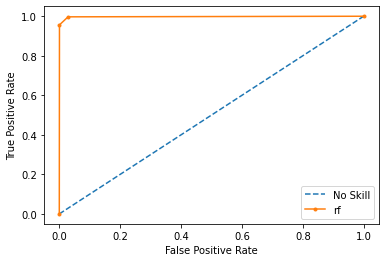

In [0]:
yhat = rf_combined.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.500000, G-Mean=0.984


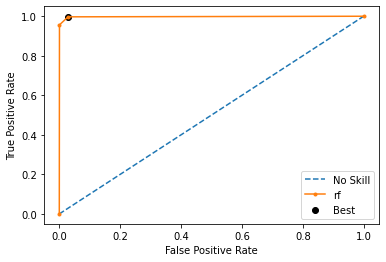

In [0]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
threshold = 0.49

predicted_proba = rf_combined.predict_proba(X_test)
predicted10 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted10)
print(accuracy)

0.9840660961935674


In [0]:
actual10 = y_test
results = confusion_matrix(actual10, predicted10) 
print('Threshold Value: ', threshold)  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual10, predicted10)*100,3))
print('Report : ')
print(classification_report(actual, predicted10))

Threshold Value:  0.49
Confusion Matrix :
[[1646   49]
 [   5 1689]]
Accuracy Score : 98.407
Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1695
           1       0.97      1.00      0.98      1694

    accuracy                           0.98      3389
   macro avg       0.98      0.98      0.98      3389
weighted avg       0.98      0.98      0.98      3389



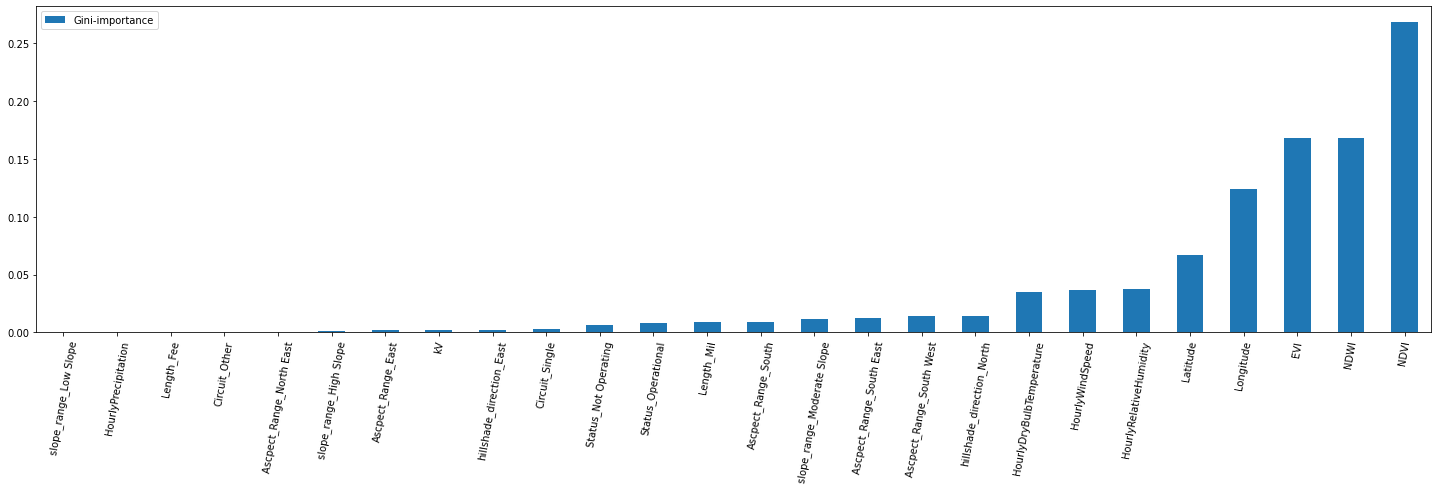

In [0]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_data_veg.columns, rf_combined.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=80, figsize=(25, 6))

In [0]:
estimator = rf_combined.estimators_[1]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names =train_data_veg.columns,
                class_names = ['Positive','Negative'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


0

In [0]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## save to drive

In [0]:
train.head()

,Unnamed: 0,Unnamed: 0.1,WBAN,DATE,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlyPrecipitation,left,top,right,bottom,id,Longitude,Latitude,target,geometry,NDVI,NDWI,EVI,kV,Length_Mil,Length_Fee,Ascpect_Range_East,Ascpect_Range_North East,Ascpect_Range_South,Ascpect_Range_South East,Ascpect_Range_South West,hillshade_direction_East,hillshade_direction_North,slope_range_High Slope,slope_range_Low Slope,slope_range_Moderate Slope,Status_Not Operating,Status_Operational,Circuit_Other,Circuit_Single
0,0,5910476,93241,2015-07-22 00:53:00,67.0,61.0,10.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
1,63,5910477,93241,2015-07-22 01:53:00,66.0,63.0,6.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
2,126,5910478,93241,2015-07-22 02:53:00,65.0,66.0,14.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
3,189,5910479,93241,2015-07-22 03:53:00,63.0,70.0,16.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
4,252,5910480,93241,2015-07-22 04:53:00,63.0,70.0,15.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0


In [0]:
tableau_com_X = train.reset_index(drop=True).drop(['Unnamed: 0', 'Unnamed: 0.1', 'WBAN', 'DATE',
        'left', 'top', 'right', 'bottom', 'id',
       'target', 'geometry'], axis=1)

In [0]:
tableau_com_y = train['target']

In [0]:
predict = rf_combined.predict(tableau_com_X)
proba = rf_combined.predict_proba(tableau_com_X)


In [0]:
train['predictions'] = predict
train['prob_0'] = proba[:,0] 
train['prob_1'] = proba[:,1]

In [0]:
train.head()

,Unnamed: 0,Unnamed: 0.1,WBAN,DATE,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlyPrecipitation,left,top,right,bottom,id,Longitude,Latitude,target,geometry,NDVI,NDWI,EVI,kV,Length_Mil,Length_Fee,Ascpect_Range_East,Ascpect_Range_North East,Ascpect_Range_South,Ascpect_Range_South East,Ascpect_Range_South West,hillshade_direction_East,hillshade_direction_North,slope_range_High Slope,slope_range_Low Slope,slope_range_Moderate Slope,Status_Not Operating,Status_Operational,Circuit_Other,Circuit_Single,predictions,prob_0,prob_1
0,0,5910476,93241,2015-07-22 00:53:00,67.0,61.0,10.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1.0,0.0
1,63,5910477,93241,2015-07-22 01:53:00,66.0,63.0,6.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1.0,0.0
2,126,5910478,93241,2015-07-22 02:53:00,65.0,66.0,14.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1.0,0.0
3,189,5910479,93241,2015-07-22 03:53:00,63.0,70.0,16.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1.0,0.0
4,252,5910480,93241,2015-07-22 04:53:00,63.0,70.0,15.0,0.0,-122.124189,38.56926,-122.114189,38.55926,1,-122.119189,38.56426,0,POLYGON ((-122.1241886091637 38.56925978424475...,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1.0,0.0


In [0]:
# train.to_csv(root_path +'combined_data.csv')

# Ensemble with stacking

In [0]:
X = train_data_veg
y = train_target_veg

In [0]:
X.head()

,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlyPrecipitation,Longitude,Latitude,NDVI,NDWI,EVI,kV,Length_Mil,Length_Fee,Ascpect_Range_East,Ascpect_Range_North East,Ascpect_Range_South,Ascpect_Range_South East,Ascpect_Range_South West,hillshade_direction_East,hillshade_direction_North,slope_range_High Slope,slope_range_Low Slope,slope_range_Moderate Slope,Status_Not Operating,Status_Operational,Circuit_Other,Circuit_Single
0,67.0,61.0,10.0,0.0,-122.119189,38.56426,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
1,66.0,63.0,6.0,0.0,-122.119189,38.56426,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
2,65.0,66.0,14.0,0.0,-122.119189,38.56426,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
3,63.0,70.0,16.0,0.0,-122.119189,38.56426,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
4,63.0,70.0,15.0,0.0,-122.119189,38.56426,0.481685,0.116296,0.398298,0.0,0,0.0,0,0,1,0,0,0,1,1,0,0,1,0,1,0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [0]:
X_train.columns

Index(['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'NDVI', 'NDWI', 'EVI',
       'kV', 'Length_Mil', 'Length_Fee', 'Ascpect_Range_East',
       'Ascpect_Range_North East', 'Ascpect_Range_South',
       'Ascpect_Range_South East', 'Ascpect_Range_South West',
       'hillshade_direction_East', 'hillshade_direction_North',
       'slope_range_High Slope', 'slope_range_Low Slope',
       'slope_range_Moderate Slope', 'Status_Not Operating',
       'Status_Operational', 'Circuit_Other', 'Circuit_Single'],
      dtype='object')

In [0]:
X_train_veg = pd.DataFrame(data=X_train,columns=['Longitude', 'Latitude', 'NDVI', 'EVI', 'NDWI'])
X_train_weather = pd.DataFrame(data=X_train,columns=['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'kV', 'Length_Mil',
       'Length_Fee', 'Ascpect_Range_East', 'Ascpect_Range_North East',
       'Ascpect_Range_South', 'Ascpect_Range_South East',
       'Ascpect_Range_South West', 'hillshade_direction_East',
       'hillshade_direction_North', 'slope_range_High Slope',
       'slope_range_Low Slope', 'slope_range_Moderate Slope',
       'Status_Not Operating', 'Status_Operational', 'Circuit_Other',
       'Circuit_Single'])

In [0]:
# X_train_veg_input = rf_veg.predict(X_train_veg)
# X_train_weather_input = rf_weather.predict(X_train_weather)

In [0]:
X_test_veg = pd.DataFrame(data=X_test,columns=['Longitude', 'Latitude', 'NDVI', 'EVI', 'NDWI'])
X_test_weather = pd.DataFrame(data=X_test,columns=['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'kV', 'Length_Mil',
       'Length_Fee', 'Ascpect_Range_East', 'Ascpect_Range_North East',
       'Ascpect_Range_South', 'Ascpect_Range_South East',
       'Ascpect_Range_South West', 'hillshade_direction_East',
       'hillshade_direction_North', 'slope_range_High Slope',
       'slope_range_Low Slope', 'slope_range_Moderate Slope',
       'Status_Not Operating', 'Status_Operational', 'Circuit_Other',
       'Circuit_Single'])

In [0]:
X_test_ensemble= pd.concat([pd.DataFrame(rf_veg.predict(X_test_veg),columns=['input'] ) ,pd.DataFrame(rf_weather.predict(X_test_weather),columns=['input'] )],axis =1)
y_test_ensemble = y_test

In [0]:
y_test.head()

4202    1
3728    1
5417    1
4068    1
9821    0
Name: target, dtype: int64

In [0]:
X_train_ensemble = pd.concat([pd.DataFrame(rf_veg.predict(X_train_veg),columns=['input'] ) ,pd.DataFrame(rf_weather.predict(X_train_weather),columns=['input'] )],axis =1)
y_train_ensemble= y_train

In [0]:
# X_test_ensemble = pd.concat([X_test_veg_input,X_test_weather_input], axis=1)
# y_test_ensemble= y_test

In [0]:
# train_target.shape

In [0]:
# test_target.shape

In [0]:
# from sklearn.linear_model import LogisticRegression

### Logistic

In [0]:
model = LogisticRegression(random_state=1)
model.fit(X_train_ensemble,y_train_ensemble)
# model.score(df_test,test_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model.score(X_test_ensemble,y_test_ensemble)

0.9524793388429752

In [0]:
predictions = model.predict(X_test_ensemble)

In [0]:
actual = y_test_ensemble
predicted = predictions
results = confusion_matrix(actual, predicted)
numpy_data = np.array([predictions, y_test_ensemble])
result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])

In [0]:
result['error'] = result['predict'] - result['target']
correct = result[result['error'] == 0]
print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))

Accuracy:0.95%


In [0]:
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(actual, predicted))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[1635   60]
 [  55  670]]
Accuracy Score : 0.9524793388429752
Report : 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1695
           1       0.92      0.92      0.92       725

    accuracy                           0.95      2420
   macro avg       0.94      0.94      0.94      2420
weighted avg       0.95      0.95      0.95      2420



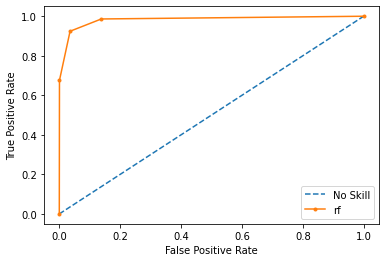

In [0]:
yhat = model.predict_proba(X_test_ensemble)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_ensemble, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### Adaboost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
classifier = AdaBoostClassifier(
    RandomForestClassifier(max_depth=1),
    n_estimators=200
)
classifier.fit(X_train_ensemble, y_train_ensemble)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                          

In [0]:
classifier.score(X_test_ensemble,y_test_ensemble)
predictions = classifier.predict(X_test_ensemble)
actual = y_test_ensemble
predicted = predictions
results = confusion_matrix(actual, predicted)
# numpy_data = np.array([predictions, y_test_ensemble])
# result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])
# result['error'] = result['predict'] - result['target']
# correct = result[result['error'] == 0]
# print('Accuracy:%.2f%%' % (correct.shape[0]/result.shape[0]))
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual, predicted)*100,3))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[1635   60]
 [  55  670]]
Accuracy Score : 95.248
Report : 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1695
           1       0.92      0.92      0.92       725

    accuracy                           0.95      2420
   macro avg       0.94      0.94      0.94      2420
weighted avg       0.95      0.95      0.95      2420



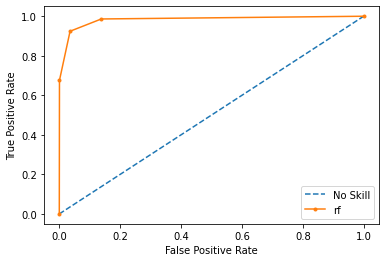

In [0]:
yhat = classifier.predict_proba(X_test_ensemble)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_ensemble, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.501698, G-Mean=0.944


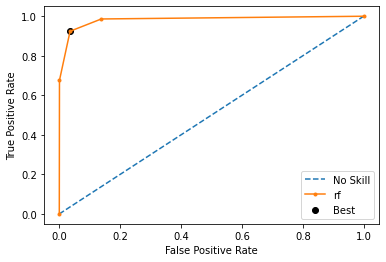

In [0]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='rf')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
threshold = 0.495

predicted_proba = classifier.predict_proba(X_test_ensemble)
predicted10 = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test_ensemble, predicted10)
print(accuracy)

0.8991735537190083


In [0]:
actual10 = y_test_ensemble
results = confusion_matrix(actual10, predicted10) 
print('threshold: ', threshold)
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',round(accuracy_score(actual10, predicted10)*100, 3))
print('Report : ')
print(classification_report(actual, predicted10))

threshold:  0.495
Confusion Matrix :
[[1461  234]
 [  10  715]]
Accuracy Score : 89.917
Report : 
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1695
           1       0.75      0.99      0.85       725

    accuracy                           0.90      2420
   macro avg       0.87      0.92      0.89      2420
weighted avg       0.92      0.90      0.90      2420



In [0]:
X_train_ensemble.head()

In [0]:
estimator = classifier.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train_ensemble.columns,
                class_names = ['Positive','Negative'],
                rounded = True, proportion = False, precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


In [0]:
print(estimator)

In [0]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [0]:
classifier.feature_importances_

In [0]:
import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_data_veg.columns, classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=80, figsize=(25, 6))

## save to drive

In [0]:
train_data_veg.columns

In [0]:
X_veg = pd.DataFrame(data=train_data_veg,columns=['Longitude', 'Latitude', 'NDVI', 'EVI', 'NDWI'])
X_weather = pd.DataFrame(data=train_data_veg,columns=['HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
       'HourlyPrecipitation', 'Longitude', 'Latitude', 'kV', 'Length_Mil',
       'Length_Fee', 'Ascpect_Range_East', 'Ascpect_Range_North East',
       'Ascpect_Range_South', 'Ascpect_Range_South East',
       'Ascpect_Range_South West', 'hillshade_direction_East',
       'hillshade_direction_North', 'slope_range_High Slope',
       'slope_range_Low Slope', 'slope_range_Moderate Slope',
       'Status_Not Operating', 'Status_Operational', 'Circuit_Other',
       'Circuit_Single'])

In [0]:
X_ensemble= pd.concat([pd.DataFrame(rf_veg.predict(X_veg),columns=['input'] ) ,pd.DataFrame(rf_weather.predict(X_weather),columns=['input'] )],axis =1)

In [0]:
y = train_data_veg['target']

In [0]:
predict = classifier.predict(X_ensemble)
proba = classifier.predict_proba(X_ensemble)

In [0]:
train_data_veg['predictions'] = predict
train_data_veg['prob_0'] = proba[:,0] 
train_data_veg['prob_1'] = proba[:,1]

In [0]:
train_data_veg.head()

In [0]:
train_data_veg.to_csv(root_path +'ensemble_data.csv')

In [0]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split

In [0]:
# train_X, test_X, train_y, test_y = train_test_split(train_data_veg, train_target_veg, random_state=1)

In [0]:
# classifier = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=1),
#     n_estimators=200
# )
# classifier.fit(train_X, train_y)

In [0]:
# predictions = classifier.predict(test_X)

In [0]:
# actual = test_y
# predicted = classifier.predict(test_X)
# results = confusion_matrix(actual, predicted)
# numpy_data = np.array([predictions, test_y])
# result = pd.DataFrame(data=np.transpose(numpy_data), columns=['predict', 'target'])